# Dataset - Google Play Review

In [1]:
import json
import pandas as pd
from tqdm import *
import seaborn as sns
import matplotlib.pyplot as plt
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from google_play_scraper import Sort, reviews, app

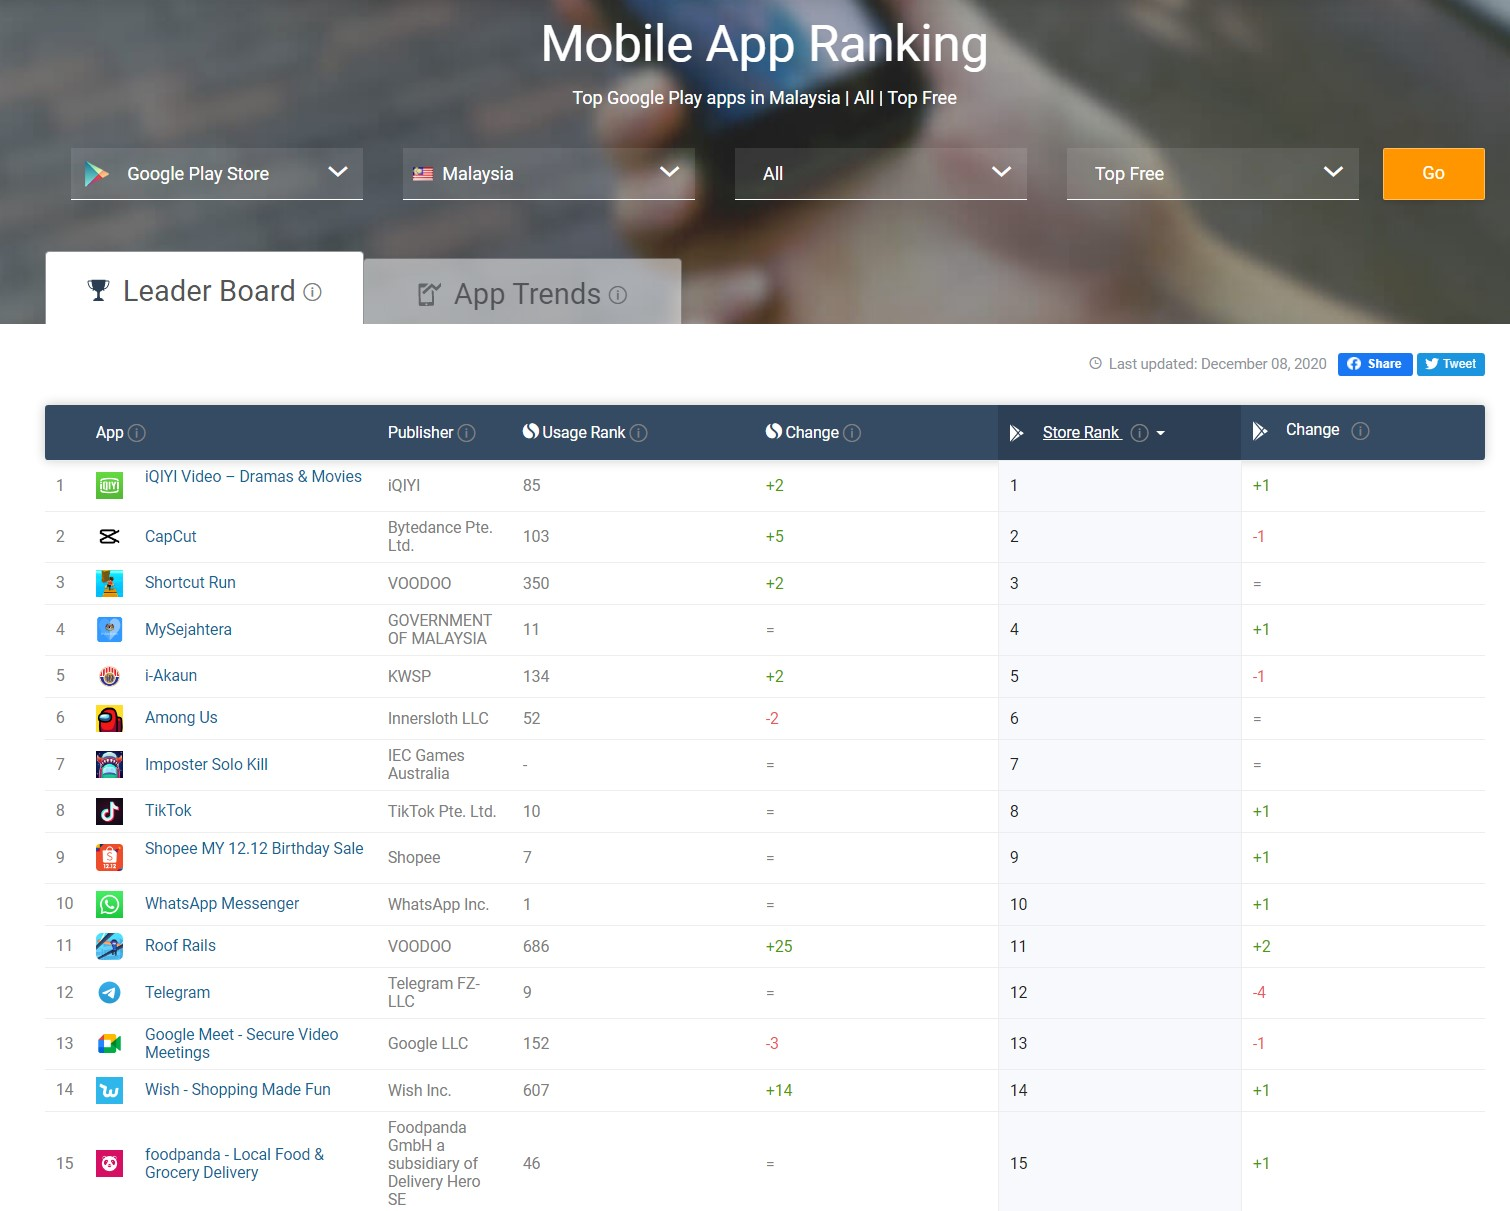

In [2]:
from IPython.display import Image
Image(filename='top_apps.jpg') 

In [3]:
top_apps = [
    'com.iqiyi.i18n',
    'com.lemon.lvoverseas',
    'my.gov.onegovappstore.mysejahtera',
    'com.ohmgames.cheatandrun',
    'com.epf.main',
    'com.innersloth.spacemafia',
    'com.iec.imposter.solo.kill',
    'com.ss.android.ugc.trill',
    'com.shopee.my',
    'com.whatsapp',
    'com.pixelbox.roofrails',
    'org.telegram.messenger',
    'com.google.android.apps.meetings',
    'com.contextlogic.wish',
    'com.global.foodpanda.android'   
]

In [4]:
app_infos = []

for ap in tqdm(top_apps):
    info  = app(ap, lang='en')
    del info['comments']
    app_infos.append(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


In [5]:
def print_json(json_object):
    json_str = json.dumps(json_object,indent=2,sort_keys=True,default=str)
    
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [6]:
print_json(app_infos[0])

{
  "adSupported": true,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 and up",
  "appId": "com.iqiyi.i18n",
  "containsAds": true,
  "contentRating": "Teen",
  "contentRatingDescription": "Diverse Content: Discretion Advised",
  "currency": "USD",
  "description": "Get the streaming service with multilingual support for FREE. Watch the MOST POPULAR asian dramas, variety shows, movies and animes.\r\n\u2022 Hottest Dramas: Hush, The Blooms at RUYI Pavilion, Love is Sweet, Hotel Trainees, Something Just Like This, More Than Friends, 18 Again, RENASCENCE, Backstreet Rookie, My Unicorn Girl, etc.\r\n\u2022 Popular Variety Shows: FOURTRY, HAHAHAHAHA, Let's party, The Rap of China, The Big Band, Youth With You, Summer Surf Shop, etc.\r\n\u2022 Exclusive Movies: Monster Hunters, Detective Dee Solitary skies killer, Ne Zha, The Untamed Fatal Journey, etc.\r\n\u2022 Awesome Animes: Attack on Titan Final Season, JUJUTSU KAISEN, One Piece, Digimon Adventure, Are You OK, etc.\r\nAll are 

In [7]:
def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

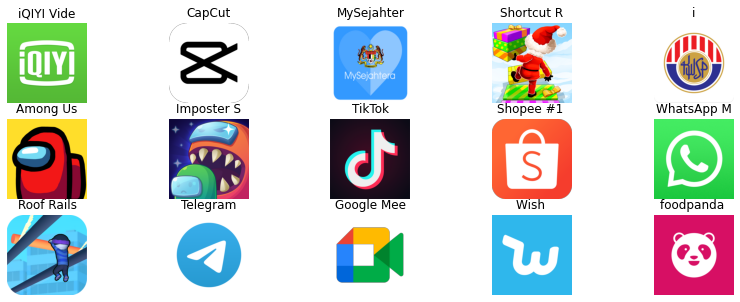

In [8]:
fig, axs = plt.subplots(3, len(app_infos) // 3, figsize=(14,5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    img = plt.imread(ai['icon'])
    
    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

In [9]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

In [10]:
app_reviews = []

for ap in tqdm(top_apps):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
                      
            rvs, _ = reviews(
                        ap,
                        lang='en',
                        country='us',
                        sort=sort_order,
                        count = 200 if score == 3 else 100,
                        filter_score_with=score)
        for r in rvs:
            r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
            r['appId'] = ap
            app_reviews.extend(rvs)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:38<00:00,  6.57s/it]


In [11]:
print_json(app_reviews[0])

{
  "appId": "com.iqiyi.i18n",
  "at": "2020-12-25 21:03:21",
  "content": "it's not installed fast\ud83d\udca2\ud83d\udca2\ud83d\udca2\ud83d\udca2\ud83d\udca2",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "2.12.0",
  "reviewId": "gp:AOqpTOHczf__hR3PzYWlH4so_vdnwUYuN-voCMcopSYAEbDVxKC45EnDMVHBCHYtTcw7ak1ZpBh4cfx0wRcrJw",
  "score": 1,
  "sortOrder": "newest",
  "thumbsUpCount": 0,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14Ggi2rRq2Q5uqivYTvc2LotpeZ0BSe7gqzI_sKm4",
  "userName": "Little star"
}



In [12]:
len(app_reviews)

1198416

In [13]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

In [14]:
import transformers
import torch
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch.utils.data import DataLoader, Dataset

In [15]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

#rcParams['figure.figzise'] = [12,8]

In [16]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
df = pd.read_csv('reviews.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [18]:
df.shape

(1198416, 12)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198416 entries, 0 to 1198415
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   reviewId              1198416 non-null  object
 1   userName              1198416 non-null  object
 2   userImage             1198416 non-null  object
 3   content               1198416 non-null  object
 4   score                 1198416 non-null  int64 
 5   thumbsUpCount         1198416 non-null  int64 
 6   reviewCreatedVersion  854800 non-null   object
 7   at                    1198416 non-null  object
 8   replyContent          207100 non-null   object
 9   repliedAt             207100 non-null   object
 10  sortOrder             1198416 non-null  object
 11  appId                 1198416 non-null  object
dtypes: int64(2), object(10)
memory usage: 109.7+ MB


In [20]:
df[['appId', 'content', 'score']].sample(30)

,appId,content,score
962330,com.google.android.apps.meetings,Very bad new version. Introduce desktop client...,1
257540,com.ohmgames.cheatandrun,THIS GAME IS WEIRD💖,2
354246,com.epf.main,Reat ud,3
13470,com.iqiyi.i18n,this is a very good app but it has a very smal...,2
7876,com.iqiyi.i18n,😏😯😏😏😊😊,1
389019,com.epf.main,Sometimes the apps takes time to reply... Epf ...,4
623491,com.ss.android.ugc.trill,Yeah yeah rriririiririr,4
576001,com.ss.android.ugc.trill,I like tiktok,2
174866,my.gov.onegovappstore.mysejahtera,Satu aplikasi yang baik tetapi perlu ada fungs...,2
915199,org.telegram.messenger,Good but need more privacy ND security for girls,3


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='score', ylabel='count'>

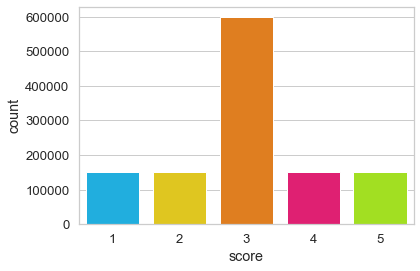

In [21]:
sns.countplot(df.score)

In [22]:
def to_sentiment(rating):
    rating = int(rating)
    
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 3
    
df['sentiment'] = df.score.apply(to_sentiment)

In [23]:
class_names = ['negative', 'neutral', 'positive']

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


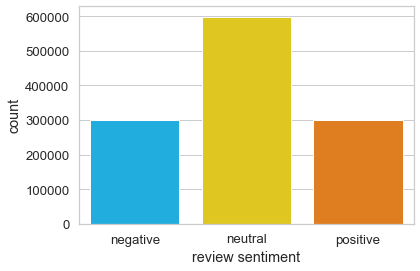

In [24]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [25]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [27]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [28]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [29]:
print(sample_txt)
print(tokens)
print(token_ids)

When was I last outside? I am stuck at home for 2 weeks.
['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
[1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [30]:
tokenizer.sep_token

'[SEP]'

In [31]:
encoding = tokenizer.encode_plus(sample_txt,
                                max_length=32,
                                add_special_tokens=True,
                                return_token_type_ids=False,
                                pad_to_max_length=True,
                                return_attention_mask=True,
                                return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [33]:
df = df.dropna()

In [34]:
token_lens = []

for txt in df.content:
    
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


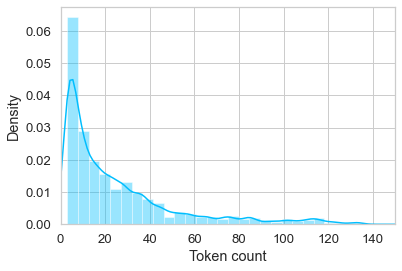

In [35]:
sns.distplot(token_lens)
plt.xlim([0,150]);
plt.xlabel('Token count');

In [36]:
MAX_LEN = 128

In [37]:
class GPReviewDataset(Dataset):
    
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                    review,
                    add_special_token=True,
                    max_length=max_len,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors='pt')
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [38]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1
    )

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    )

df_train.shape, df_val.shape, df_test.shape

((151020, 13), (8390, 13), (8390, 13))

In [39]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0)

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE),
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [40]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [41]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'])

In [42]:
bert_model.config.hidden_size

768

In [43]:
class SentimentClassifier(torch.nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = torch.nn.Dropout(p=0.8)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [44]:
model = SentimentClassifier(len(class_names))
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin